# DICOM Image Preprocessing Exploration

This notebook explores different preprocessing techniques for DICOM medical images.

## 1. Import Required Libraries

In [66]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pydicom
from tqdm import tqdm

# Set matplotlib to display plots inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

## 2. Load DICOM File

In [67]:
# Path to your DICOM file
dicom_file = r'C:\Users\agirold\Desktop\DicomAnalysis\1.3.46.423632.420000.1735982979.14.dcm'  # Update this path

# Load DICOM file
dicom_data = pydicom.dcmread(dicom_file)
image_array = dicom_data.pixel_array.astype(np.float32)

print(f"Image shape: {image_array.shape}")
print(f"Min value: {image_array.min()}")
print(f"Max value: {image_array.max()}")

Image shape: (1024, 1024)
Min value: 24770.0
Max value: 65535.0


## 3. Display Original Image

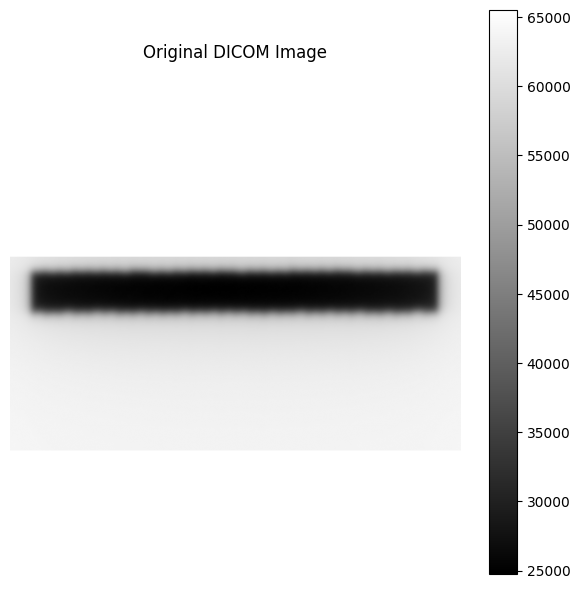

In [68]:
plt.figure(figsize=(6, 6))
plt.imshow(image_array, cmap='gray')
plt.title('Original DICOM Image')
plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.show()

## 4. Preprocessing Techniques

### 4.1 Normalization

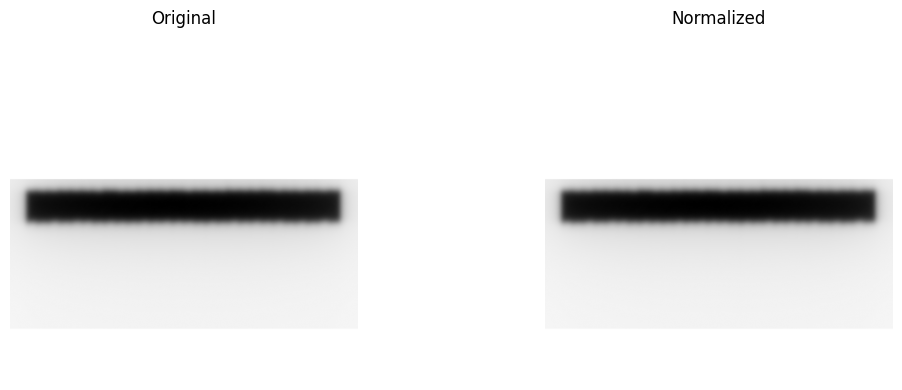

In [69]:
# Normalize image to 0-1 range
def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    normalized = (image - min_val) / (max_val - min_val)
    return normalized

normalized_img = normalize_image(image_array)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_array, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(normalized_img, cmap='gray')
plt.title('Normalized')
plt.axis('off')
plt.tight_layout()
plt.show()

### 4.2 Contrast Enhancement Techniques

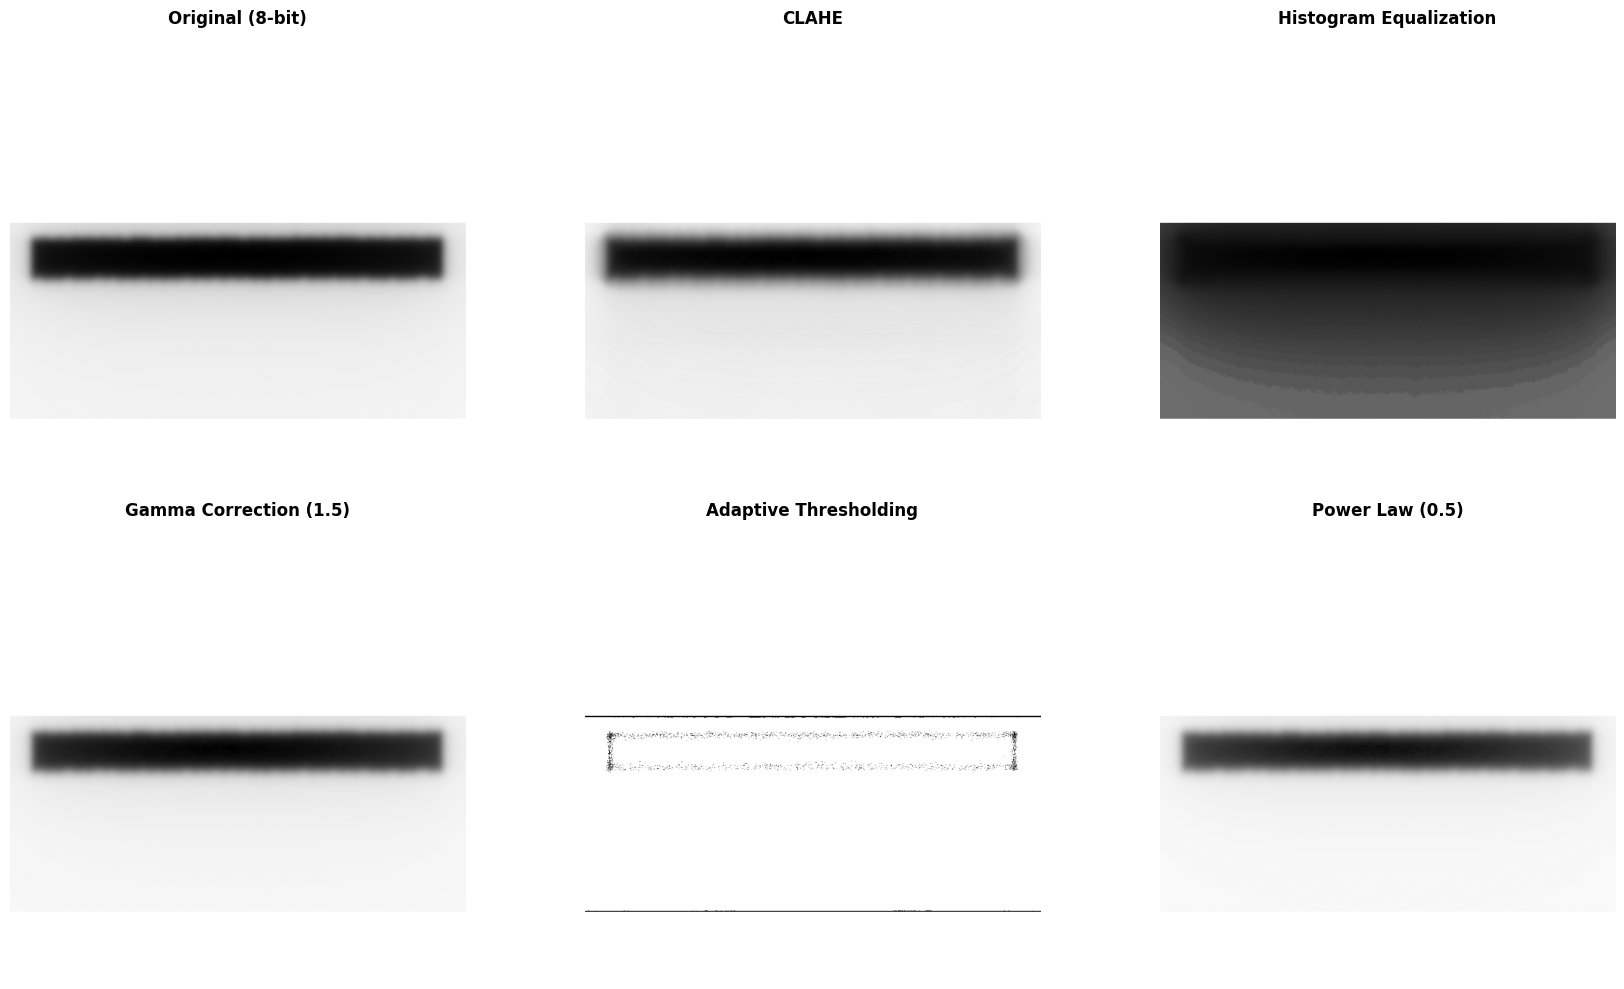


CONTRAST ENHANCEMENT METHODS

1. CLAHE: Best for local contrast improvement
   - Preserves details while enhancing contrast
   - Avoids over-amplification of noise

2. HISTOGRAM EQUALIZATION: Simple global contrast stretching
   - Can cause over-enhancement
   - Good for overall brightness distribution

3. GAMMA CORRECTION: Non-linear brightness adjustment
   - <1.0 darkens, >1.0 brightens
   - Preserves detail relationships

4. ADAPTIVE THRESHOLDING: Local binary conversion
   - Creates high contrast binary image
   - Good for edge detection preparation

5. POWER LAW: Aggressive non-linear transformation
   - Emphasizes bright and dark regions
   - Highlights edges naturally


In [70]:
# 1. CLAHE (Contrast Limited Adaptive Histogram Equalization)
img_8bit_for_contrast = cv2.normalize(normalized_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_img = clahe.apply(img_8bit_for_contrast)

# 2. Histogram Equalization
hist_eq_img = cv2.equalizeHist(img_8bit_for_contrast)

# 3. Gamma Correction (brightening)
gamma = 1.5
inv_gamma = 1.0 / gamma
table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype(np.uint8)
gamma_corrected = cv2.LUT(img_8bit_for_contrast, table)

# 4. Adaptive Thresholding (local contrast)
adaptive_thresh = cv2.adaptiveThreshold(img_8bit_for_contrast, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                         cv2.THRESH_BINARY, 11, 2)

# 5. Power Law Transformation (more aggressive gamma)
power_law = np.power(normalized_img, 0.5) * 255
power_law = power_law.astype(np.uint8)

# Display all contrast enhancement methods
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].imshow(img_8bit_for_contrast, cmap='gray')
axes[0, 0].set_title('Original (8-bit)', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(clahe_img, cmap='gray')
axes[0, 1].set_title('CLAHE', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(hist_eq_img, cmap='gray')
axes[0, 2].set_title('Histogram Equalization', fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

axes[1, 0].imshow(gamma_corrected, cmap='gray')
axes[1, 0].set_title('Gamma Correction (1.5)', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(adaptive_thresh, cmap='gray')
axes[1, 1].set_title('Adaptive Thresholding', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(power_law, cmap='gray')
axes[1, 2].set_title('Power Law (0.5)', fontsize=12, fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CONTRAST ENHANCEMENT METHODS")
print("="*60)
print("\n1. CLAHE: Best for local contrast improvement")
print("   - Preserves details while enhancing contrast")
print("   - Avoids over-amplification of noise")
print("\n2. HISTOGRAM EQUALIZATION: Simple global contrast stretching")
print("   - Can cause over-enhancement")
print("   - Good for overall brightness distribution")
print("\n3. GAMMA CORRECTION: Non-linear brightness adjustment")
print("   - <1.0 darkens, >1.0 brightens")
print("   - Preserves detail relationships")
print("\n4. ADAPTIVE THRESHOLDING: Local binary conversion")
print("   - Creates high contrast binary image")
print("   - Good for edge detection preparation")
print("\n5. POWER LAW: Aggressive non-linear transformation")
print("   - Emphasizes bright and dark regions")
print("   - Highlights edges naturally")
print("="*60)

### 4.2.1 Sharpening Techniques on CLAHE

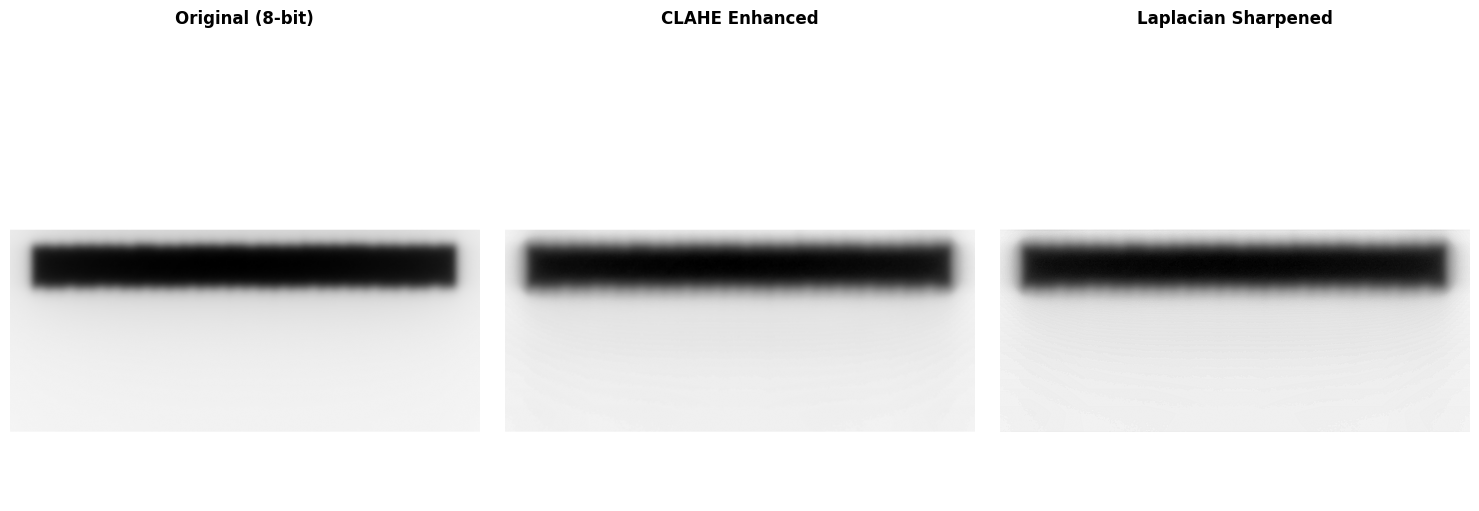

Pipeline: Normalization → CLAHE → Laplacian Sharpening


In [71]:
# Apply Laplacian Sharpening to CLAHE image

# Laplacian Sharpening
laplacian_kernel = np.array([[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]], dtype=np.float32)
laplacian_sharpened = cv2.filter2D(clahe_img, -1, laplacian_kernel)
laplacian_sharpened = np.clip(laplacian_sharpened, 0, 255).astype(np.uint8)

# Display comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_8bit_for_contrast, cmap='gray')
axes[0].set_title('Original (8-bit)', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(clahe_img, cmap='gray')
axes[1].set_title('CLAHE Enhanced', fontsize=12, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(laplacian_sharpened, cmap='gray')
axes[2].set_title('Laplacian Sharpened', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("Pipeline: Normalization → CLAHE → Laplacian Sharpening")